# Import all dependencies 

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import requests
# !pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import sys

# !pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from tensorflow.keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


/opt/anaconda3/envs/deforestation/lib/python3.9/site-packages/imageio/core/util.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Functions 

In [2]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Download the 4 band amazon dataset 

In [3]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [4]:
# Check if the folder exists
if not os.path.exists(base_dir2):
    raise FileNotFoundError(
        f"Dataset folder '{base_dir2}' not found. "
        "Please extract 'Amazon.rar' manually."
    )

print(f"Dataset is ready at: {base_dir2}")

# Path to training images folder
train_image_dir2 = os.path.join(base_dir2, "Training/image")

# List all image files
image_files2 = os.listdir(train_image_dir2)
print(f"Found {len(image_files2)} images in Training/images")


Dataset is ready at: ./AMAZON/
Found 499 images in Training/images


# Process the 4 band dataset 

In [5]:
# Ingest images and normalise

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

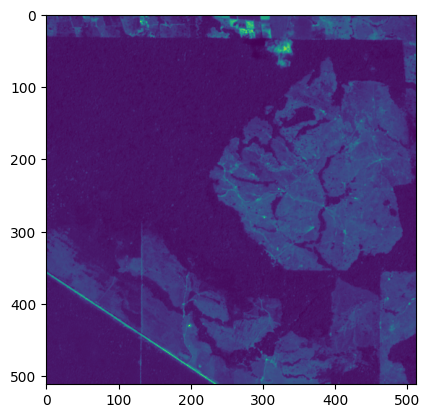

In [6]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [7]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [8]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

# The Model - Attention UNet 

In [11]:
'''
  Convolutional block with two conv layers and two activation layers
'''
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam


def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    # model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.compile(optimizer = Adam(learning_rate = lr),
              loss = 'binary_crossentropy',
              metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [12]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 512, 512, 3)]           0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (1, 512, 512, 16)            448       ['input_2[0][0]']             
                                                                                                  
 activation_26 (Activation)  (1, 512, 512, 16)            0         ['conv2d_30[0][0]']           
                                                                                                  
 conv2d_31 (Conv2D)          (1, 512, 512, 16)            2320      ['activation_26[0][0]']       
                                                                                              

# Train and save the model 

In [13]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
250/250 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8111 - mse: 0.1265  
Epoch 1: val_accuracy improved from -inf to 0.90186, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 110s 436ms/step - loss: 0.3952 - accuracy: 0.8111 - mse: 0.1265 - val_loss: 0.2494 - val_accuracy: 0.9019 - val_mse: 0.0735
Epoch 2/60


/opt/anaconda3/envs/deforestation/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9265 - mse: 0.0564  
Epoch 2: val_accuracy improved from 0.90186 to 0.93485, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 139s 556ms/step - loss: 0.1980 - accuracy: 0.9265 - mse: 0.0564 - val_loss: 0.1677 - val_accuracy: 0.9349 - val_mse: 0.0485
Epoch 3/60
250/250 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9400 - mse: 0.0453  
Epoch 3: val_accuracy improved from 0.93485 to 0.94936, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 149s 597ms/step - loss: 0.1584 - accuracy: 0.9400 - mse: 0.0453 - val_loss: 0.1303 - val_accuracy: 0.9494 - val_mse: 0.0376
Epoch 4/60
250/250 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9505 - mse: 0.0373  
Epoch 4: val_accuracy improved from 0.94936 to 0.95708, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 146s 583ms/st

In [15]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

# Print Training Metrics 

In [16]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

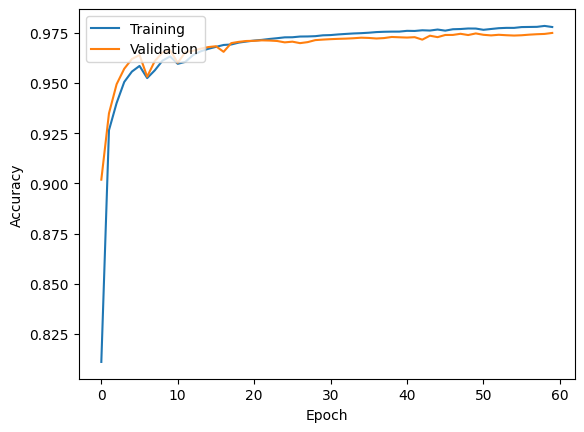

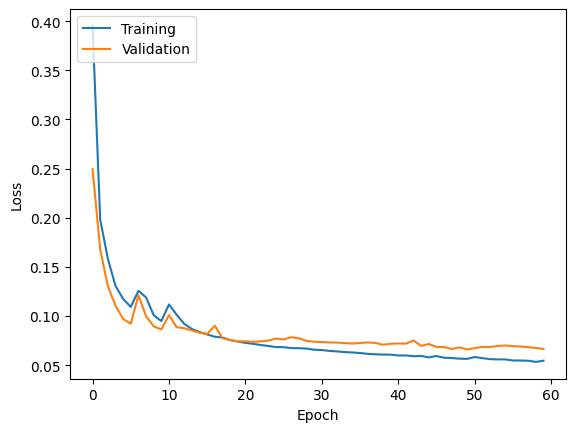

In [17]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# Generate and print model metrics on validation set 

In [18]:
# Scores of the model 

am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

# Precision and recall of the model

am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

# F1-scores of each model
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

1/1 [==============================] - 0s 95ms/step


/opt/anaconda3/envs/deforestation/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 99ms/step


In [19]:
# Print score eval results for the model
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

# Print precision eval results for the model
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

# Print recall eval results for the model
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

# Print f1-score eval results for the model
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

Attention U-Net accuracy:  0.9748955535888671 0.022842814346818653
Attention U-Net precision:  0.9770853538789581 0.019049220003907186
Attention U-Net recall:  0.9748955535888671 0.022842814346818653
Attention U-Net F1-score:  0.975989225436727


In [20]:

# Create metrics dictionary
metrics_4d_amazon_val = {
    'classifier': ['Attention U-Net'],
    'accuracy': [np.mean(am_unet_4d_score)],
    'precision': [np.mean(am_unet_4d_precision)],
    'recall': [np.mean(am_unet_4d_recall)],
    'f1_score': [np.mean(am_unet_4d_f1_score)],
    'accuracy_std': [np.std(am_unet_4d_score)],
    'precision_std': [np.std(am_unet_4d_precision)],
    'recall_std': [np.std(am_unet_4d_recall)]
}

# Convert to DataFrame
metrics_4d_amazon_val = pd.DataFrame(metrics_4d_amazon_val)

# Save to CSV
metrics_4d_amazon_val.to_csv('Amazon_Attention_UNet_Validation_Metrics.csv', index=False)

print("4 band amazon validation metrics has been saved")


4 band amazon validation metrics has been saved


# generate and print model metrics on train set 

In [21]:
# Amazon trained model on Amazon test data
# Scores of the model
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of the model
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 [==============================] - 0s 93ms/step


/opt/anaconda3/envs/deforestation/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 87ms/step


In [22]:
# Print metrics for Amazon on Amazon Test set
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

Attention U-Net score:  0.9749332427978515 0.016463576547673407
Attention U-Net precision:  0.9760641804112957 0.015382323615773583
Attention U-Net recall:  0.9749332427978515 0.016463576547673407
Attention U-Net F1-score:  0.9754983838184191


In [23]:
# Create metrics dictionary
metrics_4d_amazon_test = {
    'classifier': ['Attention U-Net'],
    'accuracy': [np.mean(am_unet_4d_score_test)],
    'precision': [np.mean(am_unet_4d_precision_test)],
    'recall': [np.mean(am_unet_4d_recall_test)],
    'f1_score': [np.mean(am_unet_4d_f1_score_test)],
    'accuracy_std': [np.std(am_unet_4d_score_test)],
    'precision_std': [np.std(am_unet_4d_precision_test)],
    'recall_std': [np.std(am_unet_4d_recall_test)]
}

# Convert to DataFrame
metrics_4d_amazon_test= pd.DataFrame(metrics_4d_amazon_test)

# Save to CSV
metrics_4d_amazon_test.to_csv('Amazon_Attention_UNet_Test_Metrics.csv', index=False)

print("4 band amazon test metrics has been saved")


4 band amazon test metrics has been saved
